In [140]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import make_scorer, precision_score
from xgboost import XGBClassifier
import warnings
import math
warnings.filterwarnings("ignore")


In [96]:
#configurations
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [141]:
data_base = pd.read_csv('../data/data_base.csv')

In [142]:
data_base.columns

Index(['ticker', 'date', 'vol_1y', 'max_1y', 'min_1y', 'sma_1y', 'sma_2y',
       'volatility_1y', 'revenue', 'eps', 'ebitda', 'netinc', 'roe',
       'evebitda', 'fcfps', 'pb', 'pe', 'marketcap', 'ebit', 'capex', 'ncfo',
       'equity', 'de', 'revenue_yoy', 'ebitda_yoy', 'ebit_yoy', 'eps_yoy',
       'equity_yoy', 'capex_yoy', 'pe_yoy', 'pb_yoy', 'fcfps_yoy', 'ncfo_yoy',
       'closeadj', 'ret_6m', 'ret_12m', 'risk_free_rate', 'target_12m_final',
       'signed_log_revenue', 'signed_log_ebitda', 'signed_log_ebit',
       'signed_log_marketcap', 'signed_log_equity', 'ebit_margin',
       'net_margin', 'capex_to_revenue', 'fcf_yield', 'ps', 'ret_12m_vol',
       'ret_6m_vol', 'sma_diff', 'dist_max_1y', 'dist_min_1y', 'vol_over_sma',
       'cap_category', 'cap_Large Cap', 'cap_Mega Cap', 'cap_Mid Cap',
       'cap_Small Cap', 'target_class'],
      dtype='object')

In [143]:
data_base.drop(columns=['cap_category', 'closeadj', 'max_1y', 'min_1y'], inplace=True)

Validación de Datos para la selección de Hiperparámetros -> 1999-2003

In [144]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import precision_score
from itertools import product
from tqdm.notebook import tqdm

df = data_base.copy()

# Asegurar tipo datetime
df['date'] = pd.to_datetime(df['date'])

# Asegurar que no hay NaNs ni infs
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(0, inplace=True)

# Filtrar solo los años iniciales para buscar hiperparámetros
df_cv = df[(df['date'].dt.year >= 1999) & (df['date'].dt.year <= 2003)]

# Extraer columnas válidas para features
features = [col for col in df.columns if col not in ['target_class', 'date', 'ticker', 'target_12m_final']]
target = 'target_class'

# Crear folds por año completo
folds = {year: df_cv[df_cv['date'].dt.year == year] for year in range(1999, 2004)}


Especificación de Grid de Hiperparámetros

In [145]:
# Pequeño espacio para eficiencia inicial (puedes ampliarlo luego)
param_grid = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 150, 200],
    'reg_alpha': [0, 1, 2],
    'reg_lambda': [1],
    'subsample': [1.0],
    'colsample_bytree': [0.8, 1.0],
}

param_combinations = list(product(*param_grid.values()))
param_names = list(param_grid.keys())


Validación de Hiperparámetros

In [146]:
results = []

for comb in tqdm(param_combinations):
    params = dict(zip(param_names, comb))
    params.update({
        'objective': 'multi:softprob',
        'eval_metric': 'mlogloss',
        'num_class': 5,
        'use_label_encoder': False
    })

    precision_scores = []

    for i in range(1, 5):  # 4 validaciones: 1999→2000, ..., 1999–2002→2003
        train_years = list(range(1999, 1999 + i))
        val_year = 1999 + i

        train_df = pd.concat([folds[y] for y in train_years])
        val_df = folds[val_year]

        X_train = train_df[features]
        y_train = train_df[target]
        X_val = val_df[features]
        y_val = val_df[target]

        model = xgb.XGBClassifier(**params)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_val)

        try:
            prec = precision_score(y_val, y_pred, average=None, labels=[4])[0]
        except IndexError:
            prec = 0.0  # No predijo ninguna clase 4

        precision_scores.append(prec)

    results.append({
        'params': params,
        'mean_precision_4': np.mean(precision_scores)
    })


  0%|          | 0/108 [00:00<?, ?it/s]

Convertir Resultados a df

In [147]:
# Convertir resultados a DataFrame
results_df = pd.DataFrame(results)

# Seleccionar mejor combinación
best_row = results_df.loc[results_df['mean_precision_4'].idxmax()]
best_params = best_row['params']

print("Mejores hiperparámetros encontrados:")
for k, v in best_params.items():
    print(f"{k}: {v}")

print("\nPrecisión clase 4 media:", round(best_row['mean_precision_4'], 4))


Mejores hiperparámetros encontrados:
max_depth: 8
learning_rate: 0.1
n_estimators: 100
reg_alpha: 2
reg_lambda: 1
subsample: 1.0
colsample_bytree: 1.0
objective: multi:softprob
eval_metric: mlogloss
num_class: 5
use_label_encoder: False

Precisión clase 4 media: 0.246


Guardar best-Hiperparámetros de forma persistente

In [148]:
import pickle

with open("../models/xbgoost_hiperparametros.pkl", "wb") as f:
    pickle.dump(best_params, f)


Recuperar best-Hiperparámetros

In [186]:
with open("../models/xbgoost_hiperparametros.pkl", "rb") as f:
    best_params = pickle.load(f)


Entrenar Modelo:
- Ventana de entrenamiento 4 años
- Ventana de test 1 año

Seleccionamos las 20 empresas con mayor posibilidad de pertenecer a la clase 4

In [ ]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

# Asumimos que ya tienes 'best_params' y el DataFrame limpio
n_years = 4  # ventana de entrenamiento de 4 años
results = []

for test_year in range(2004, 2025):
    train_start = test_year - n_years
    train_end = test_year - 1

    train_df = df[(df['date'].dt.year >= train_start) & (df['date'].dt.year <= train_end)]
    test_df = df[df['date'].dt.year == test_year]

    if train_df.empty or test_df.empty:
        continue

    X_train = train_df[features]
    y_train = train_df['target_class']
    X_test = test_df[features]
    y_test = test_df['target_class']

    model = xgb.XGBClassifier(**best_params)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)

    # Calcular métricas para clase 4
    try:
        precision_4 = precision_score(y_test, y_pred, average=None, labels=[4])[0]
        recall_4 = recall_score(y_test, y_pred, average=None, labels=[4])[0]
    except IndexError:
        precision_4 = 0.0
        recall_4 = 0.0

    accuracy = accuracy_score(y_test, y_pred)

    # Seleccionar top 20 empresas por probabilidad clase 4
    test_df = test_df.copy()
    test_df['proba_class_4'] = y_proba[:, 4]
    class4 = test_df.sort_values('proba_class_4', ascending=False)

    mean_return = class4['target_12m_final'].mean()
    volatility = class4['target_12m_final'].std()

    results.append({
        'year': test_year,
        'accuracy': accuracy,
        'precision_4': precision_4,
        'recall_4': recall_4,
        'mean_return_class4': mean_return,
        'volatility_class4': volatility,
        'tickers': class4['ticker'].tolist()
    })


check: Cual es la probabilidad media de cada clase a pertencer a la clase 4? ... los resultados no parecen buenos

In [188]:
summary = (
    class4
    .groupby('target_class')['proba_class_4']
    .agg(['count','mean'])
    .rename(columns={'count':'n_obs','mean':'avg_proba4'})
)
print(summary)


              n_obs  avg_proba4
target_class                   
0               101    0.195613
1               100    0.201867
2               101    0.177147
3               100    0.199246
4               101    0.159813


    year  accuracy  precision_4  recall_4  mean_return_class4
0   2004  0.232000     0.242424  0.160000            0.106057
1   2005  0.246000     0.342857  0.240000            0.179495
2   2006  0.224000     0.235955  0.210000            0.116882
3   2007  0.220000     0.222222  0.180000           -0.080505
4   2008  0.240000     0.184211  0.210000           -0.388679
5   2009  0.178000     0.106061  0.070000            0.778434
6   2010  0.230461     0.209302  0.090000            0.198803
7   2011  0.230000     0.202381  0.170000            0.045470
8   2012  0.258000     0.400000  0.020000            0.165679
9   2013  0.198000     0.253165  0.200000            0.244976
10  2014  0.220000     0.292135  0.260000            0.132001
11  2015  0.201195     0.198276  0.227723           -0.012338
12  2016  0.192460     0.186047  0.158416            0.166030
13  2017  0.269307     0.268817  0.247525            0.115157
14  2018  0.253465     0.226415  0.237624            0.069384
15  2019

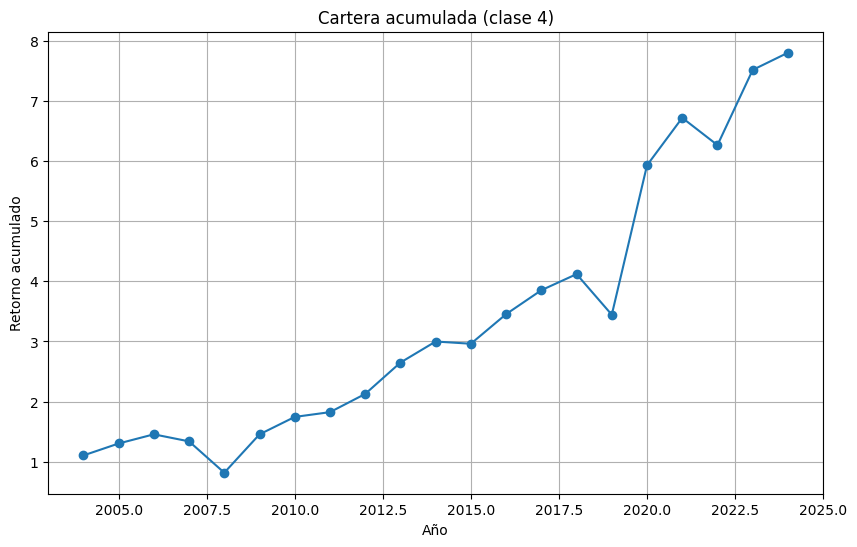

In [190]:
results_df = pd.DataFrame(results)

# Mostrar resumen
print(results_df[['year', 'accuracy', 'precision_4', 'recall_4', 'mean_return_class4']])

# Retorno acumulado
results_df['cumulative_return'] = (1 + results_df['mean_return_class4']).cumprod()

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(results_df['year'], results_df['cumulative_return'], marker='o')
plt.title('Cartera acumulada (clase 4)')
plt.xlabel('Año')
plt.ylabel('Retorno acumulado')
plt.grid(True)
plt.show()


Al parecer los resultados no son tan buenos, no difieren mucho del índice sp500. Quizás probando solo con el top20 empresas?

### top20
Modelo entrenado con XGBOOST, compone cartera con top20 acciones con mayor probabilidad de pertenecer a la clase 4 (percentil 80% de retornos de cada año)

In [201]:
from sklearn.metrics import precision_score, recall_score, accuracy_score
from collections import defaultdict
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix


# Ventana fija de entrenamiento (por ejemplo, 4 años)
n_years = 4

# Inicializar estructuras
results = []
selected_companies = defaultdict(list)
feature_importance_by_year = {}

for test_year in range(2004, 2025):
    train_start = test_year - n_years
    train_end = test_year - 1

    train_df = df[(df['date'].dt.year >= train_start) & (df['date'].dt.year <= train_end)]
    test_df = df[df['date'].dt.year == test_year]

    if train_df.empty or test_df.empty:
        continue

    X_train = train_df[features]
    y_train = train_df['target_class']
    X_test = test_df[features]
    y_test = test_df['target_class']

    # Entrenamiento
    model = xgb.XGBClassifier(**best_params)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    conf_mat = confusion_matrix(y_test, y_pred, labels=[0, 1, 2, 3, 4])
    
    # Métricas generales
    accuracy = accuracy_score(y_test, y_pred)
    try:
        precision_4 = precision_score(y_test, y_pred, average=None, labels=[4])[0]
        recall_4 = recall_score(y_test, y_pred, average=None, labels=[4])[0]
    except IndexError:
        precision_4, recall_4 = 0.0, 0.0

    # Probabilidades y selección top 20
    test_df = test_df.copy()
    test_df['proba_class_4'] = y_proba[:, 4]
    top20 = test_df.sort_values('proba_class_4', ascending=False).head(20)

    mean_return = top20['target_12m_final'].mean()
    volatility = top20['target_12m_final'].std()

    # Guardar métricas anuales
    results.append({
        'year': test_year,
        'accuracy': accuracy,
        'precision_4': precision_4,
        'recall_4': recall_4,
        'mean_return_top20': mean_return,
        'volatility_top20': volatility,
        'n_class4_real': (test_df['target_class'] == 4).sum(),
        'confusion_matrix': conf_mat.tolist()
    })

    # Guardar empresas seleccionadas
    for _, row in top20.iterrows():
        selected_companies[test_year].append({
            'ticker': row['ticker'],
            'ret_12m': row['target_12m_final'],
            'proba_class_4': row['proba_class_4']
        })

    # Guardar feature importance
    feature_importance_by_year[test_year] = dict(zip(features, model.feature_importances_))


In [202]:
# Convertir métricas generales a DataFrame
results_df = pd.DataFrame(results)

# Calcular retorno acumulado
results_df['cumulative_return'] = (1 + results_df['mean_return_top20']).cumprod()

# Mostrar resumen
print("📊 Métricas por año:")

display(results_df[
    ['year', 'accuracy', 'precision_4', 'recall_4', 
     'mean_return_top20', 'volatility_top20', 
     'n_class4_real', 'cumulative_return']
])


# Guardar empresas seleccionadas
empresas_df = []
for year, companies in selected_companies.items():
    for entry in companies:
        entry['year'] = year
        empresas_df.append(entry)
empresas_df = pd.DataFrame(empresas_df)

# Guardar feature importance
feat_imp_df = pd.DataFrame(feature_importance_by_year).T



📊 Métricas por año:


,year,accuracy,precision_4,recall_4,mean_return_top20,volatility_top20,n_class4_real,cumulative_return
0,2004,0.232000,0.242424,0.160000,-0.007604,0.379651,100,0.992396
1,2005,0.246000,0.342857,0.240000,0.275787,0.465721,100,1.266086
2,2006,0.224000,0.235955,0.210000,0.002966,0.261913,100,1.269841
3,2007,0.220000,0.222222,0.180000,-0.062787,0.314791,100,1.190111
4,2008,0.240000,0.184211,0.210000,-0.460271,0.252930,100,0.642338
5,2009,0.178000,0.106061,0.070000,0.563811,0.629013,100,1.004495
6,2010,0.230461,0.209302,0.090000,0.144875,0.189540,100,1.150021
7,2011,0.230000,0.202381,0.170000,0.007572,0.234802,100,1.158729
8,2012,0.258000,0.400000,0.020000,0.086700,0.226436,100,1.259191
9,2013,0.198000,0.253165,0.200000,0.305682,0.214397,100,1.644102


Los resultados parecen ser incluso peores, las matrices de confusión (aunque no se muestran aquí). Cuando las ejecuto suelen fallar bastante y tienen precision bajo, alto número de falsos positivos, especialmente empresas del percentil 20%

! check (no es relevante)

In [203]:
df_by_year = { 
    year: pd.DataFrame(comps) 
    for year, comps in selected_companies.items() 
}


! check (no es relevante)

In [204]:
df_by_year[2019]['ret_12m']

0    -0.467319
1     0.782132
2    -0.385814
3    -0.555601
4    -0.090861
5    -0.313153
6    -0.540056
7    -0.339738
8    -0.331400
9    -0.202234
10    0.367782
11   -0.078005
12   -0.223601
13   -0.044938
14   -0.322522
15   -0.120522
16    0.063584
17   -0.198882
18   -0.572867
19   -0.321103
Name: ret_12m, dtype: float64

Quizás es demasiado optimista componer carteras solo con el percentil 80 de retornos. 

Hipótesis: estas empresas sufren grandes cambios durante el año y suelen ser controversiales. Por ejemplo en 2019 que no fue un año necesariamente malo, una gran mayoría de las empresas en cartera tienen retornos negativos. A continuación se observa la media de rangos de retornos para cada clase sobre el dataset completo. (En realidad los quitiles se aplican por año para evitar sesgo) . Como se puede observar la clase 4 compone (de forma general) empresas con retornos elevadamente altos. Podría ser interesante incluir la clase 3 también. 

In [205]:
# Verificamos que hay 5 clases (0 a 4)
assert df['target_class'].nunique() == 5, "No hay 5 clases. Revisa la definición de target_class."

# Obtener percentiles usados para crear las clases
quantile_bins = df['ret_12m'].quantile([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])

# Mostrar como tabla clara
print("📊 Rangos de retorno (%) por clase (quintiles):")
for i in range(5):
    lower = quantile_bins.iloc[i]
    upper = quantile_bins.iloc[i+1]
    print(f"Clase {i}: {lower:.2%}  →  {upper:.2%}")


📊 Rangos de retorno (%) por clase (quintiles):
Clase 0: -97.65%  →  -15.18%
Clase 1: -15.18%  →  2.13%
Clase 2: 2.13%  →  16.38%
Clase 3: 16.38%  →  35.73%
Clase 4: 35.73%  →  865.26%


XGBOOST top20 empresas con mayor probabilidad de pertenecer a clase 3 o 4 (indiferentemente)

In [220]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix
from collections import defaultdict
import xgboost as xgb
import pandas as pd
import numpy as np

# Ventana fija de entrenamiento
n_years = 4

results               = []
selected_companies    = defaultdict(list)
feature_importance_by_year = {}

for test_year in range(2004, 2025):
    train_start = test_year - n_years
    train_end   = test_year - 1

    train_df = df[(df['date'].dt.year >= train_start) & (df['date'].dt.year <= train_end)]
    test_df  = df[df['date'].dt.year == test_year]

    if train_df.empty or test_df.empty:
        continue

    X_train, y_train = train_df[features], train_df['target_class']
    X_test,  y_test  = test_df[features],  test_df['target_class']

    # ——— Entrenamiento desde cero para este fold ———
    model = xgb.XGBClassifier(**best_params)
    model.fit(X_train, y_train)

    # ——— Predicción ———
    y_pred  = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    conf_mat = confusion_matrix(y_test, y_pred, labels=[0,1,2,3,4])

    # ——— Métricas globales (clase 4 sigue como referencia) ———
    accuracy  = accuracy_score(y_test, y_pred)
    try:
        precision_4 = precision_score(y_test, y_pred, average=None, labels=[4])[0]
        recall_4    = recall_score(y_test,   y_pred, average=None, labels=[4])[0]
    except IndexError:
        precision_4 = recall_4 = 0.0

    # ——— Probabilidades y selección top-20 (clase 3 o 4) ———
    test_df            = test_df.copy()
    test_df['proba_3'] = y_proba[:, 3]
    test_df['proba_4'] = y_proba[:, 4]
    test_df['proba_34'] = test_df['proba_3'] + test_df['proba_4']   # P(clase 3 OR 4)

    # Ordenar por la probabilidad combinada y tomar las 20 mejores
    top20 = (test_df
             .sort_values('proba_34', ascending=False)
             .head(20))

    mean_return = top20['target_12m_final'].mean()
    volatility  = top20['target_12m_final'].std()

    # ——— Guardar métricas anuales ———
    results.append({
        'year'              : test_year,
        'accuracy'          : accuracy,
        'precision_4'       : precision_4,
        'recall_4'          : recall_4,
        'mean_return_top20' : mean_return,
        'volatility_top20'  : volatility,
        'n_class3_4_real'   : int((test_df['target_class'].isin([3,4])).sum()),
        'confusion_matrix'  : conf_mat.tolist()
    })

    # ——— Guardar empresas seleccionadas ———
    for _, row in top20.iterrows():
        selected_companies[test_year].append({
            'ticker'         : row['ticker'],
            'ret_12m'        : row['target_12m_final'],
            'proba_class_34' : row['proba_34']
        })

    # ——— Importancia de variables ———
    feature_importance_by_year[test_year] = dict(zip(features, model.feature_importances_))




Visualizar resultados en tabla (estética), guardar empresas, feature importance

In [221]:
# Convertir métricas generales a DataFrame
results_df = pd.DataFrame(results)

# Calcular retorno acumulado
results_df['cumulative_return'] = (1 + results_df['mean_return_top20']).cumprod()

# Mostrar resumen
print("📊 Métricas por año:")

display(results_df[
    ['year', 'accuracy', 'precision_4', 'recall_4', 
     'mean_return_top20', 'volatility_top20', 
     'n_class3_4_real', 'cumulative_return']
])


# Guardar empresas seleccionadas
empresas_df = []
for year, companies in selected_companies.items():
    for entry in companies:
        entry['year'] = year
        empresas_df.append(entry)
empresas_df = pd.DataFrame(empresas_df)

# Guardar feature importance
feat_imp_df = pd.DataFrame(feature_importance_by_year).T



📊 Métricas por año:


,year,accuracy,precision_4,recall_4,mean_return_top20,volatility_top20,n_class3_4_real,cumulative_return
0,2004,0.232000,0.242424,0.160000,0.170881,0.301352,200,1.170881
1,2005,0.246000,0.342857,0.240000,0.105127,0.371208,200,1.293973
2,2006,0.224000,0.235955,0.210000,0.141302,0.177165,200,1.476814
3,2007,0.220000,0.222222,0.180000,-0.177708,0.283484,200,1.214372
4,2008,0.240000,0.184211,0.210000,-0.358660,0.220670,200,0.778826
5,2009,0.178000,0.106061,0.070000,0.590485,0.639530,200,1.238711
6,2010,0.230461,0.209302,0.090000,0.163410,0.132469,200,1.441129
7,2011,0.230000,0.202381,0.170000,0.181538,0.204058,200,1.702748
8,2012,0.258000,0.400000,0.020000,0.218492,0.152837,200,2.074784
9,2013,0.198000,0.253165,0.200000,0.268729,0.178601,200,2.632338


Interesante! estos resultados si baten al mercado 1€ invertido en 2004 se convierte en 10€ en 2024 vs. el sp500 1€ invertido se convierte en 7.5€

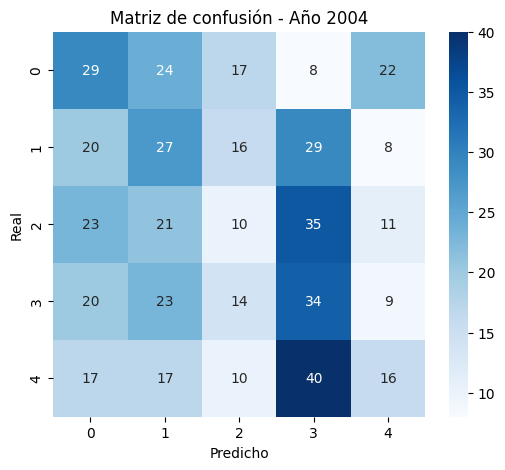

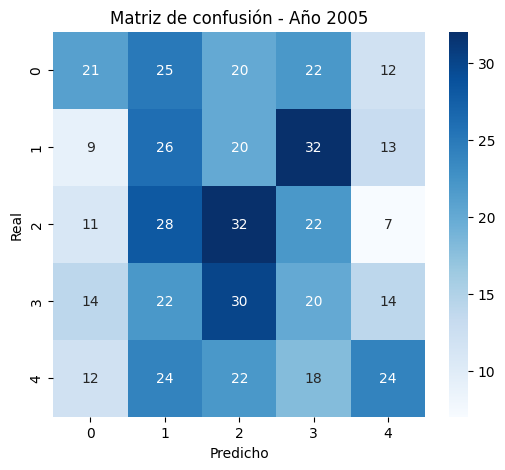

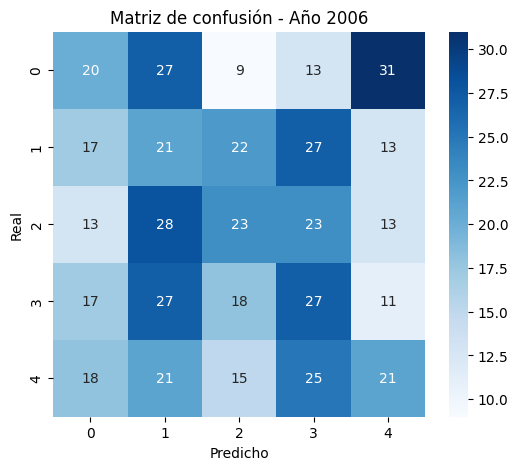

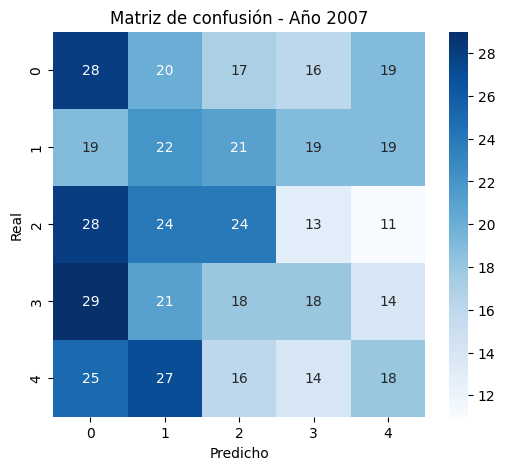

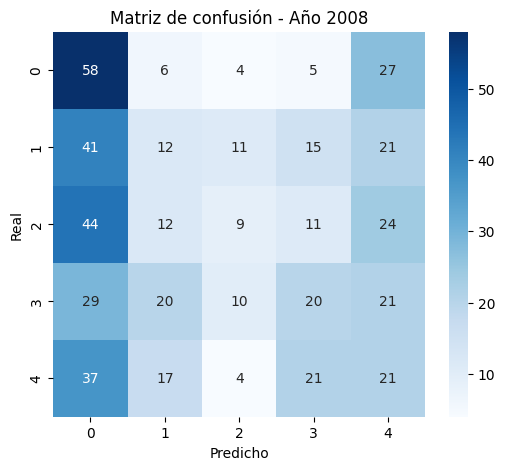

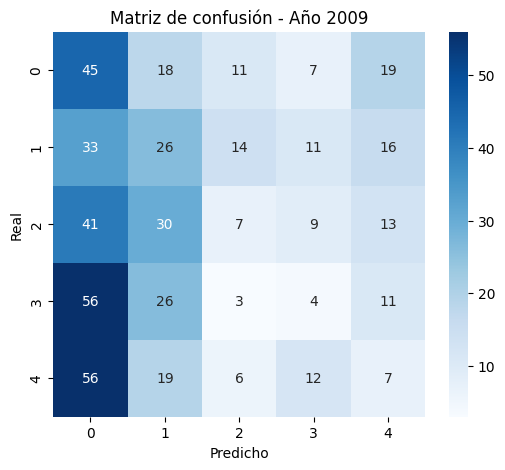

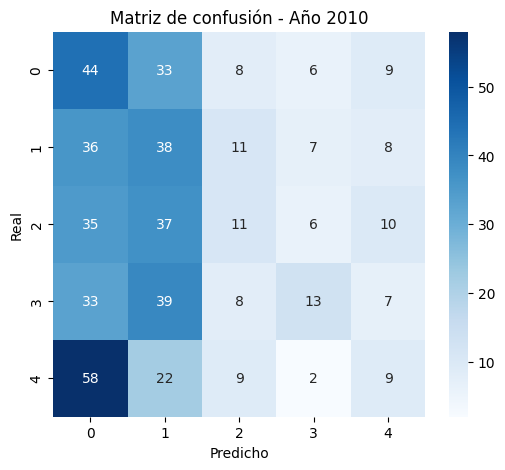

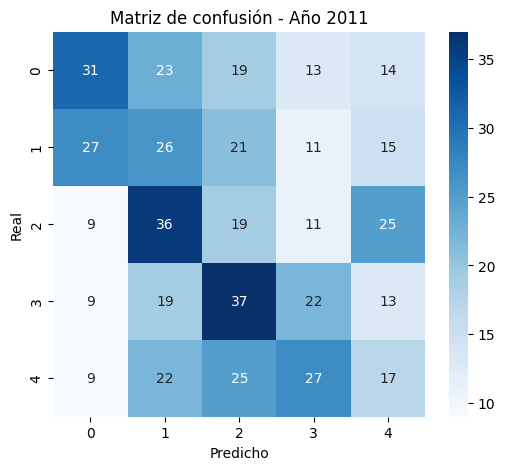

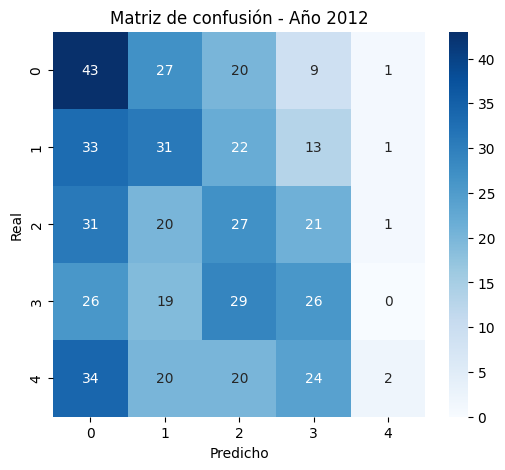

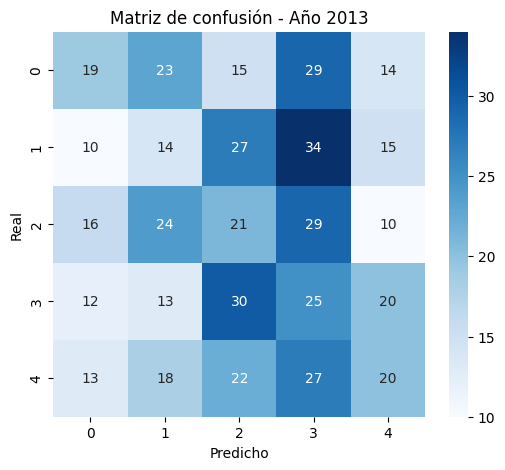

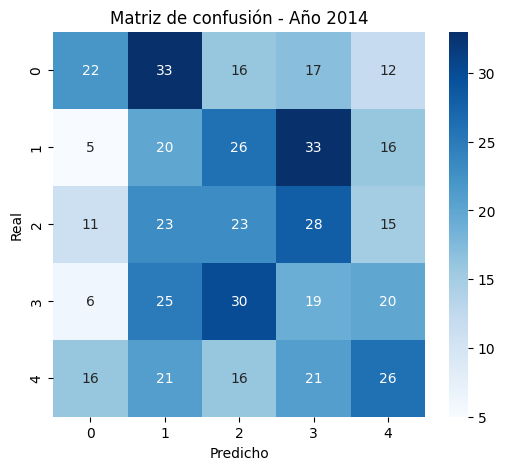

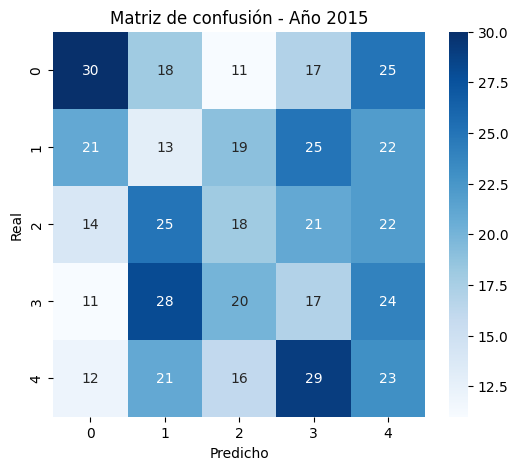

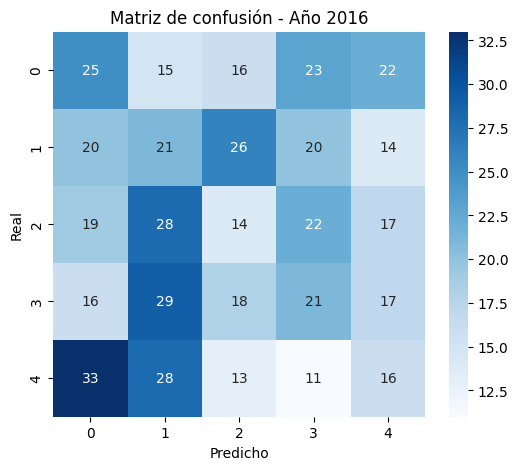

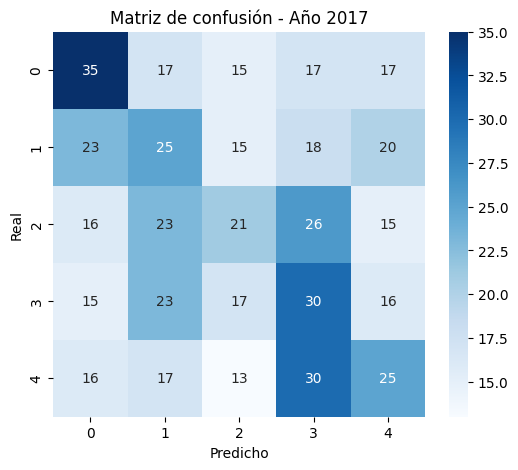

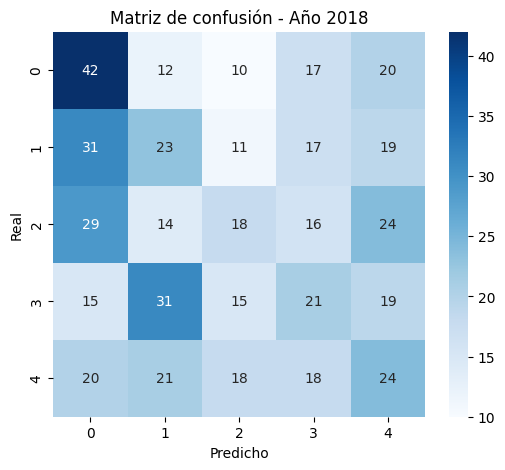

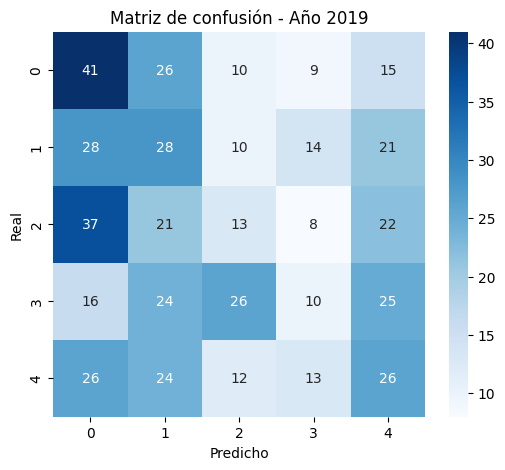

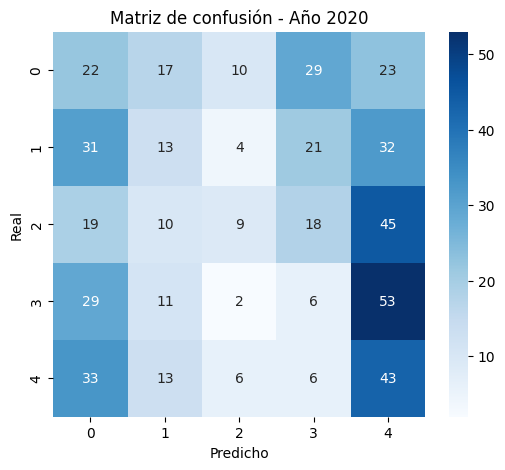

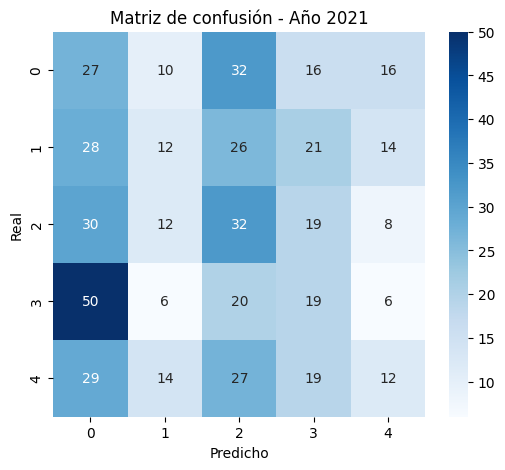

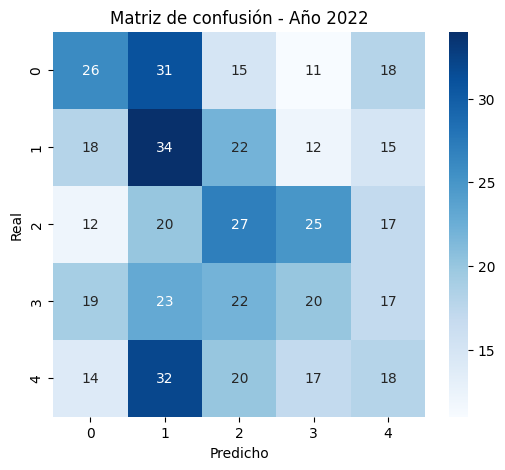

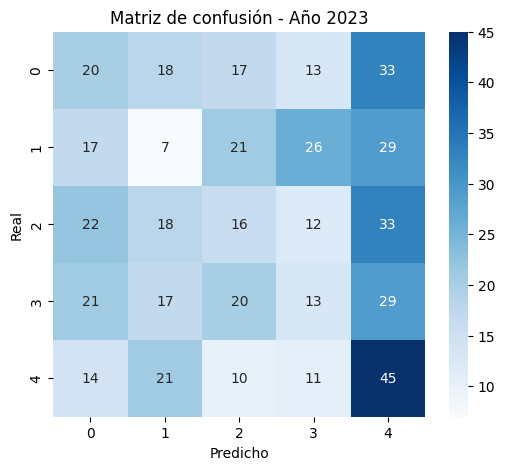

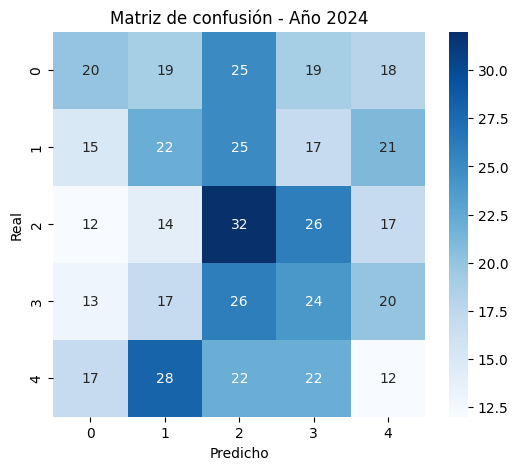

In [222]:
import seaborn as sns
import matplotlib.pyplot as plt

for i, row in results_df.iterrows():
    year = row['year']
    conf = np.array(row['confusion_matrix'])

    plt.figure(figsize=(6, 5))
    sns.heatmap(conf, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1,2,3,4], yticklabels=[0,1,2,3,4])
    plt.title(f"Matriz de confusión - Año {year}")
    plt.xlabel("Predicho")
    plt.ylabel("Real")
    plt.show()


Feauture Importance

In [213]:
for year in sorted(feature_importance_by_year.keys()):
    print(f"\n📊 Año {year} - Top 10 features:")
    importance = feature_importance_by_year[year]
    top_feats = sorted(importance.items(), key=lambda x: x[1], reverse=True)[:10]
    for feat, score in top_feats:
        print(f"  {feat}: {round(score, 4)}")



📊 Año 2004 - Top 10 features:
  risk_free_rate: 0.04050000011920929
  fcf_yield: 0.03449999913573265
  volatility_1y: 0.03400000184774399
  sma_diff: 0.03310000151395798
  sma_1y: 0.03229999914765358
  marketcap: 0.029100000858306885
  ret_12m: 0.02669999934732914
  pe: 0.025100000202655792
  sma_2y: 0.02370000071823597
  dist_max_1y: 0.023399999365210533

📊 Año 2005 - Top 10 features:
  fcf_yield: 0.03959999978542328
  sma_1y: 0.031599998474121094
  risk_free_rate: 0.03099999949336052
  dist_max_1y: 0.030400000512599945
  marketcap: 0.02850000001490116
  volatility_1y: 0.027400000020861626
  vol_over_sma: 0.026900000870227814
  sma_2y: 0.026399999856948853
  ret_12m: 0.025699999183416367
  pe: 0.02449999935925007

📊 Año 2006 - Top 10 features:
  sma_1y: 0.03269999846816063
  risk_free_rate: 0.030300000682473183
  dist_max_1y: 0.02979999966919422
  ebitda: 0.027899999171495438
  cap_Mid Cap: 0.02759999968111515
  fcf_yield: 0.026900000870227814
  net_margin: 0.025100000202655792
  pb:

Evolución de Feature Importance

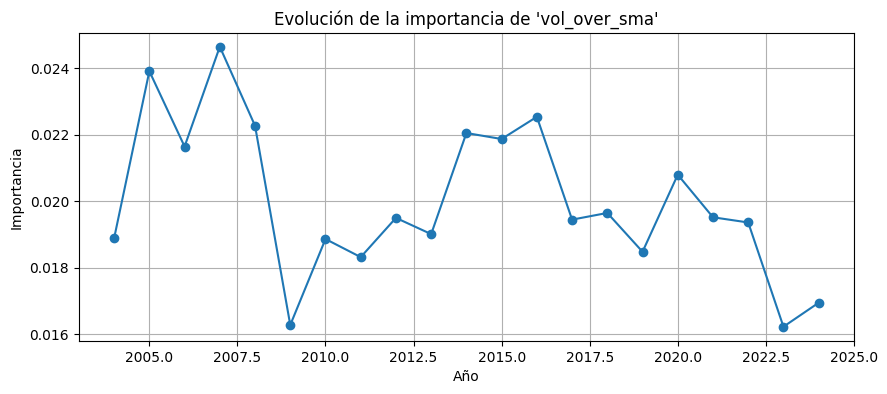

In [183]:
import matplotlib.pyplot as plt

def plot_feature_evolution(feature_name):
    years = sorted(feature_importance_by_year.keys())
    scores = [feature_importance_by_year[y].get(feature_name, 0) for y in years]
    
    plt.figure(figsize=(10, 4))
    plt.plot(years, scores, marker='o')
    plt.title(f"Evolución de la importancia de '{feature_name}'")
    plt.xlabel("Año")
    plt.ylabel("Importancia")
    plt.grid(True)
    plt.show()

# Ejemplo
plot_feature_evolution("vol_over_sma")


--------------------------------------------------------------------------------------------------------------------------------
basura (de aqui para abajo)
--------------------------------------------------------------------------------------------------------------------------------

In [30]:
# Crear diccionario: año → DataFrame
folds = {year: df_cv[df_cv['date'].dt.year == year] for year in range(1999, 2004)}


In [6]:
# Precision específica para clase 4
def precision_class_4(y_true, y_pred):
    return precision_score(y_true, y_pred, labels=[4], average='macro', zero_division=0)

scorer = make_scorer(precision_class_4)


In [7]:
xgb_clf = XGBClassifier(objective='multi:softprob', num_class=5, use_label_encoder=False, eval_metric='mlogloss', verbosity=0)

# Rango reducido para acelerar RandomizedSearch
param_dist = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 4, 6],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'gamma': [0, 0.1, 1],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 5, 10]
}


Comprobar - Hay valores infinitos o nan's? Si es así necesitamos eliminarlos antes de poder entrenar el modelo

In [8]:
# Solo columnas numéricas
X_numeric = X.select_dtypes(include=[np.number])

# Contar NaNs
n_nan = X_numeric.isna().sum()

# Contar inf y -inf (por columna)
n_posinf = np.isinf(X_numeric.to_numpy()).sum(axis=0)
n_neginf = np.isinf(-X_numeric.to_numpy()).sum(axis=0)

# Crear DataFrame de resultados
df_issues = pd.DataFrame({
    'feature': X_numeric.columns,
    'NaN': n_nan.values,
    '+Inf': n_posinf,
    '-Inf': n_neginf
})

# Filtrar columnas con problemas
df_issues = df_issues[(df_issues['NaN'] > 0) | (df_issues['+Inf'] > 0) | (df_issues['-Inf'] > 0)]

# Mostrar
df_issues.sort_values(by=['NaN', '+Inf', '-Inf'], ascending=False).reset_index(drop=True)


,feature,NaN,+Inf,-Inf
0,capex_yoy,0,5,5
1,fcfps_yoy,0,2,2


Eliminar valores infinitos

In [9]:
# Seleccionar solo columnas numéricas
X_numeric = X.select_dtypes(include=[np.number])

# Chequeo robusto
print("¿Hay NaNs?", X_numeric.isna().any().any())
print("¿Hay Inf?", np.isinf(X_numeric.to_numpy()).any())

# Reemplazo de inf por NaN y eliminación de filas incompletas
X_clean = X_numeric.replace([np.inf, -np.inf], np.nan).dropna()

# También ajustamos y para que coincida con las filas limpias
y_clean = y.loc[X_clean.index]

# Reemplazamos X y y originales por los limpios
X = X_clean
y = y_clean


¿Hay NaNs? False
¿Hay Inf? True


Comprobar - Aún hay valores infinitos?

In [10]:
# Solo columnas numéricas
X_numeric = X.select_dtypes(include=[np.number])

# Contar NaNs
n_nan = X_numeric.isna().sum()

# Contar inf y -inf (por columna)
n_posinf = np.isinf(X_numeric.to_numpy()).sum(axis=0)
n_neginf = np.isinf(-X_numeric.to_numpy()).sum(axis=0)

# Crear DataFrame de resultados
df_issues = pd.DataFrame({
    'feature': X_numeric.columns,
    'NaN': n_nan.values,
    '+Inf': n_posinf,
    '-Inf': n_neginf
})

# Filtrar columnas con problemas
df_issues = df_issues[(df_issues['NaN'] > 0) | (df_issues['+Inf'] > 0) | (df_issues['-Inf'] > 0)]

# Mostrar
df_issues.sort_values(by=['NaN', '+Inf', '-Inf'], ascending=False).reset_index(drop=True)


,feature,NaN,+Inf,-Inf


Mejores hiperparámetros encontrados:
{'subsample': 1.0, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 1.0}

Mejor precisión clase 4 media (TimeSeriesSplit):
0.9880751038620985


XGBoostError: [16:55:10] C:\actions-runner\_work\xgboost\xgboost\src\data\gradient_index.h:100: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`